Door open state classification

At first, import packages to be used for the experiments

In [1]:
import os, sys
cwd = os.getcwd()
module_path = os.path.dirname(cwd)  # target working directory

sys.path = [item for item in sys.path if item != module_path]  # remove module_path from sys.path
sys.path.append(module_path)  # add module_path to sys.path

import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

from pyrcn.base import InputToNode, PredefinedWeightsInputToNode, NodeToNode
from pyrcn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from pyrcn.model_selection import SequentialSearchCV
from pyrcn.echo_state_network import SeqToSeqESNClassifier
from pyrcn.model_selection import SequentialSearchCV

from sklearn.base import clone
from sklearn.metrics import make_scorer, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, ParameterGrid
from sklearn.cluster import MiniBatchKMeans
from sklearn.utils.fixes import loguniform
from scipy.stats import uniform
from joblib import dump, load

#Options
plt.rc('image', cmap='RdBu')
plt.rc('font', family='serif', serif='Times')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)

set_matplotlib_formats('png', 'pdf')

In [2]:
def read_file(fname,Nfr=-1):
    tmp= open(fname+'.txt', 'rb');a=tmp.read();tmp.close();T=len(a) # Just to know how many frames (T) are there in the file
    if Nfr!=-1:
        T=np.min((T,Nfr))
    dim=[30,30] # Dimension of each frame
    N_fr=dim[0]*dim[1] # size of the input vector
    yuvfile= open(fname+'.yuv', 'rb') # Opening the video file
    door_state_file= open(fname+'.txt', 'rb') # Opening the annotation file
    TARGET=np.zeros((T, 3))
    FRAMES=np.zeros((T,N_fr))
    for t in tqdm(range(T)): # for each frame    
        fr2=np.zeros(N_fr) 
        frame = yuvfile.read(N_fr)
        for i in range(N_fr):
            fr2[i]=frame[i]
        # ----------------------------------    
        fr2=fr2/255.0 # Normalizing the pixel values to [0,1]
        FRAMES[t,:]=fr2
        TARGET[t,int(door_state_file.read(1))] = 1 # setting the desired output class to 1
    return FRAMES, TARGET

In [3]:
try:
    X_train, X_test, y_train, y_test = load(r"E:\RCN_CICSyN2015\Seq_video_dataset_large.joblib")
except FileNotFoundError:
    n_files = 3

    X_total = [None] * n_files
    y_total = [None] * n_files
    n_sequences_total = [None] * n_files
    for k in range(n_files):
        X_total[k], y_total[k] = read_file(r"E:\RCN_CICSyN2015\Seq_" + str(k + 1))

    X_train_list = []
    y_train_list = []
    X_test_list = []
    y_test_list = []

    for k in range(n_files):
        n_sequences_total[k] = int(len(X_total[k]) / 5400)
        X_total[k] = np.array_split(X_total[k], n_sequences_total[k])
        y_total[k] = np.array_split(y_total[k], n_sequences_total[k])
        for m, (X, y) in enumerate(zip(X_total[k], y_total[k])):
            if m < int(.5*n_sequences_total[k]):
                X_train_list.append(X)
                y_train_list.append(y)
            else:
                X_test_list.append(X)
                y_test_list.append(y)

    X_train = np.empty(shape=(len(X_train_list), ), dtype=object)
    y_train = np.empty(shape=(len(y_train_list), ), dtype=object)
    X_test = np.empty(shape=(len(X_test_list), ), dtype=object)
    y_test = np.empty(shape=(len(y_test_list), ), dtype=object)

    for k, (X, y) in enumerate(zip(X_train_list, y_train_list)):
        X_train[k] = X.astype(float)
        y_train[k] = y.astype(int)

    for k, (X, y) in enumerate(zip(X_test_list, y_test_list)):
        X_test[k] = X.astype(float)
        y_test[k] = y.astype(int)
    
    dump([X_train, X_test, y_train, y_test], r"E:\RCN_CICSyN2015\Seq_video_dataset_large.joblib")

In [4]:
X_train.shape, X_train[0].shape, y_train.shape, y_train[0].shape

((76,), (5471, 900), (76,), (5471, 3))

In [5]:
X_test.shape, X_test[0].shape, y_test.shape, y_test[0].shape

((76,), (5471, 900), (76,), (5471, 3))

In [6]:
initially_fixed_params = {'hidden_layer_size': 50,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': loguniform(1e-5, 1e1)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(mean_squared_error, greater_is_better=False, needs_proba=True)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(mean_squared_error, greater_is_better=False, needs_proba=True)}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(mean_squared_error, greater_is_better=False, needs_proba=True)}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(mean_squared_error, greater_is_better=False, needs_proba=True)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3),
            ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step4)]

base_esn = SeqToSeqESNClassifier(**initially_fixed_params)

try:
    sequential_search = load("../sequential_search_RICSyN2015_large.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_esn, searches=searches).fit(X_train, y_train)
    dump(sequential_search, "../sequential_search_RICSyN2015_large.joblib")  # TODO: undo the "large" settings!

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


esn = sequential_search.best_estimator_

y_pred_train = esn.predict_proba(X=X_train)
cm = confusion_matrix(np.argmax(np.concatenate(y_train), axis=1), np.argmax(np.concatenate(y_pred_train), axis=1))
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(np.argmax(np.concatenate(y_train), axis=1), np.argmax(np.concatenate(y_pred_train), axis=1), digits=10)))

y_pred_test = esn.predict(X=X_test)
cm = confusion_matrix(np.argmax(np.concatenate(y_test), axis=1), np.argmax(np.concatenate(y_pred_test), axis=1))
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2]).plot()
print("Classification training report for estimator %s:\n%s\n" % (esn, classification_report(np.argmax(np.concatenate(y_test), axis=1), np.argmax(np.concatenate(y_pred_test), axis=1), digits=10)))

In [7]:
print(sequential_search.all_best_params_)
print(sequential_search.all_best_score_)

{'step1': {'input_scaling': 0.8548753109694546, 'spectral_radius': 0.04654387147165173}, 'step2': {'leakage': 0.045705630998014515}, 'step3': {'bias_scaling': 0.0}, 'step4': {'alpha': 1.3289448722869188e-05}}
{'step1': -0.07147318695589659, 'step2': -0.06959131450448691, 'step3': -0.06959131450448691, 'step4': -0.06959128279136254}


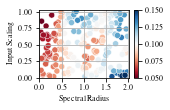

In [11]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
df["mean_test_score"] = -df["mean_test_score"]
df.mean_test_score = df.mean_test_score.clip(upper=1.5e-1)
fig = plt.figure()
ax = sns.scatterplot(x="param_spectral_radius", y="param_input_scaling", hue="mean_test_score", palette='RdBu', data=df)
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")

norm = plt.Normalize(5e-2, 1.5e-1)
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
plt.xlim((0, 2.01))
plt.ylim((0, 1.03))

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)
fig.set_size_inches(2, 1.25)
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.grid()
plt.savefig('Basic_ESN_IS_SR.pdf', bbox_inches='tight', pad_inches=0)

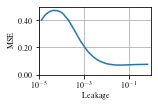

In [12]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_leakage", y="mean_test_score")
ax.set_xscale('log')
plt.xlabel("Leakage")
plt.ylabel("MSE")
plt.xlim((1e-5, 1e0))
plt.ylim((0.0, 0.5))
# ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.grid()
plt.savefig('Basic_ESN_LR.pdf', bbox_inches='tight', pad_inches=0)

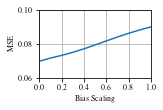

In [13]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score")
plt.xlabel("Bias Scaling")
plt.ylabel("MSE")
plt.xlim((0, 1))
plt.ylim((0.06, 0.1))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.grid()
plt.savefig('Basic_ESN_BS.pdf', bbox_inches='tight', pad_inches=0)

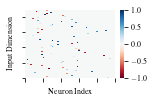

In [92]:
# idx = np.random.randint(0, 400, 50)
idx = range(50)

fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.heatmap(data=sequential_search.best_estimator_.input_to_node.input_weights.todense()[:, idx], cmap="RdBu", vmin=-1.0, vmax=1.0)
ax.invert_yaxis()
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.xlabel("Neuron Index")
plt.ylabel("Input Dimension")
# plt.imshow(sequential_search.best_estimator_.input_to_node.input_weights.todense()[:, idx])
# plt.colorbar()
plt.savefig('Basic_ESN_Input_Weights.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
num_row = 3
num_col = 3# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(2,1.25), sharex='all', sharey='all')
for k, i in enumerate(idx):
    ax = axes[k//num_col, k%num_col]
    im = ax.imshow(sequential_search.best_estimator_.input_to_node.input_weights.toarray()[:, i].reshape(30, 30), cmap='gray', vmin=-1, vmax=1)
plt.subplots_adjust(wspace=-0.63, hspace=0.1)
cbar_ax = fig.add_axes([0.78, 0.15, 0.02, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('Basic_ESN_Input_Weights_2.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
from sklearn.metrics import accuracy_score


base_esn = clone(sequential_search.best_estimator_)

param_grid = {'hidden_layer_size': [50, 100, 200, 400, 800, 1600],
              'random_state': range(1, 11)}

for params in ParameterGrid(param_grid):
    esn = clone(base_esn).set_params(**params).fit(X=X_train, y=y_train, n_jobs=8)
    y_pred = esn.predict_proba(X_test)
    score = accuracy_score(np.argmax(np.concatenate(y_test), axis=1), np.argmax(np.concatenate(y_pred), axis=1))
    print("ESN with params {0} achieved score of {1}".format(params, score))

In [15]:
kmeans = MiniBatchKMeans(n_clusters=50, n_init=200, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=2, random_state=0)
kmeans.fit(X=np.concatenate(np.concatenate((X_train, X_test))))
w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
# w_in = np.pad(w_in, ((0, 1600 - 50), (0, 0)), mode='constant', constant_values=0)

Init 1/200 with method: k-means++
Inertia for init 1/200: 220.015947
Init 2/200 with method: k-means++
Inertia for init 2/200: 235.665723
Init 3/200 with method: k-means++
Inertia for init 3/200: 265.945149
Init 4/200 with method: k-means++
Inertia for init 4/200: 233.109900
Init 5/200 with method: k-means++
Inertia for init 5/200: 234.979095
Init 6/200 with method: k-means++
Inertia for init 6/200: 242.673941
Init 7/200 with method: k-means++
Inertia for init 7/200: 241.613927
Init 8/200 with method: k-means++
Inertia for init 8/200: 239.506606
Init 9/200 with method: k-means++
Inertia for init 9/200: 239.139242
Init 10/200 with method: k-means++
Inertia for init 10/200: 228.184797
Init 11/200 with method: k-means++
Inertia for init 11/200: 241.102791
Init 12/200 with method: k-means++
Inertia for init 12/200: 246.797111
Init 13/200 with method: k-means++
Inertia for init 13/200: 239.714191
Init 14/200 with method: k-means++
Inertia for init 14/200: 235.021051
Init 15/200 with method:

Init 116/200 with method: k-means++
Inertia for init 116/200: 232.738933
Init 117/200 with method: k-means++
Inertia for init 117/200: 244.323647
Init 118/200 with method: k-means++
Inertia for init 118/200: 270.771785
Init 119/200 with method: k-means++
Inertia for init 119/200: 246.711422
Init 120/200 with method: k-means++
Inertia for init 120/200: 267.117892
Init 121/200 with method: k-means++
Inertia for init 121/200: 248.875977
Init 122/200 with method: k-means++
Inertia for init 122/200: 240.119105
Init 123/200 with method: k-means++
Inertia for init 123/200: 242.042455
Init 124/200 with method: k-means++
Inertia for init 124/200: 264.170219
Init 125/200 with method: k-means++
Inertia for init 125/200: 224.784373
Init 126/200 with method: k-means++
Inertia for init 126/200: 228.721931
Init 127/200 with method: k-means++
Inertia for init 127/200: 242.469295
Init 128/200 with method: k-means++
Inertia for init 128/200: 225.595854
Init 129/200 with method: k-means++
Inertia for ini

Minibatch iteration 24/831300: mean batch inertia: 1.012114, ewa inertia: 0.826957 
Minibatch iteration 25/831300: mean batch inertia: 0.867764, ewa inertia: 0.826967 
Minibatch iteration 26/831300: mean batch inertia: 0.736242, ewa inertia: 0.826945 
Minibatch iteration 27/831300: mean batch inertia: 0.777823, ewa inertia: 0.826933 
Minibatch iteration 28/831300: mean batch inertia: 0.817088, ewa inertia: 0.826931 
Minibatch iteration 29/831300: mean batch inertia: 0.997079, ewa inertia: 0.826972 
Minibatch iteration 30/831300: mean batch inertia: 0.967553, ewa inertia: 0.827006 
Minibatch iteration 31/831300: mean batch inertia: 0.756214, ewa inertia: 0.826989 
Minibatch iteration 32/831300: mean batch inertia: 0.985727, ewa inertia: 0.827027 
Minibatch iteration 33/831300: mean batch inertia: 0.990212, ewa inertia: 0.827066 
Minibatch iteration 34/831300: mean batch inertia: 0.998859, ewa inertia: 0.827108 
Minibatch iteration 35/831300: mean batch inertia: 0.845115, ewa inertia: 0.

In [16]:
initially_fixed_params = {'hidden_layer_size': 50,
                          'k_in': 10,
                          'input_scaling': 0.4,
                          'input_activation': 'identity',
                          'bias_scaling': 0.0,
                          'spectral_radius': 0.0,
                          'leakage': 0.1,
                          'k_rec': 10,
                          'reservoir_activation': 'tanh',
                          'bi_directional': False,
                          'wash_out': 0,
                          'continuation': False,
                          'alpha': 1e-3,
                          'random_state': 42}

step1_esn_params = {'input_scaling': uniform(loc=1e-2, scale=1),
                    'spectral_radius': uniform(loc=0, scale=2)}

step2_esn_params = {'leakage': loguniform(1e-5, 1e0)}
step3_esn_params = {'bias_scaling': np.linspace(0.0, 1.0, 11)}
step4_esn_params = {'alpha': loguniform(1e-5, 1e1)}

kwargs_step1 = {'n_iter': 200, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step2 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step3 = {'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}
kwargs_step4 = {'n_iter': 50, 'random_state': 42, 'verbose': 1, 'n_jobs': -1, 'scoring': make_scorer(accuracy_score)}

# The searches are defined similarly to the steps of a sklearn.pipeline.Pipeline:
searches = [('step1', RandomizedSearchCV, step1_esn_params, kwargs_step1),
            ('step2', RandomizedSearchCV, step2_esn_params, kwargs_step2),
            ('step3', GridSearchCV, step3_esn_params, kwargs_step3),
            ('step4', RandomizedSearchCV, step4_esn_params, kwargs_step4)]

base_km_esn = SeqToSeqESNClassifier(input_to_node=PredefinedWeightsInputToNode(predefined_input_weights=w_in.T),
                                    **initially_fixed_params)

try:
    sequential_search = load("../sequential_search_RICSyN2015_km_large.joblib")
except FileNotFoundError:
    sequential_search = SequentialSearchCV(base_km_esn, searches=searches).fit(X_train, y_train)
    dump(sequential_search, "../sequential_search_RICSyN2015_km_large.joblib")

C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator StandardScaler from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Steiner\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:334: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.23.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report


km_esn = sequential_search.best_estimator_

y_pred_train = km_esn.predict_proba(X=X_train)
cm = confusion_matrix(np.argmax(np.concatenate(y_train), axis=1), np.argmax(np.concatenate(y_pred_train), axis=1))
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2]).plot()
print("Classification training report for estimator %s:\n%s\n" % (km_esn, classification_report(np.argmax(np.concatenate(y_train), axis=1), np.argmax(np.concatenate(y_pred_train), axis=1), digits=10)))

y_pred_test = km_esn.predict(X=X_test)
cm = confusion_matrix(np.argmax(np.concatenate(y_test), axis=1), np.argmax(np.concatenate(y_pred_test), axis=1))
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1, 2]).plot()
print("Classification training report for estimator %s:\n%s\n" % (km_esn, classification_report(np.argmax(np.concatenate(y_test), axis=1), np.argmax(np.concatenate(y_pred_test), axis=1), digits=10)))

In [17]:
print(sequential_search.all_best_params_)
print(sequential_search.all_best_score_)

{'step1': {'input_scaling': 0.11077800137742665, 'spectral_radius': 0.036443651303099456}, 'step2': {'leakage': 0.020540519425388454}, 'step3': {'bias_scaling': 0.1}, 'step4': {'alpha': 1.3289448722869188e-05}}
{'step1': -0.06508223058066562, 'step2': -0.061503019038455384, 'step3': -0.060997830142201025, 'step4': -0.05634491711518295}


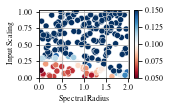

In [19]:
df = pd.DataFrame(sequential_search.all_cv_results_["step1"])
df["mean_test_score"] = -df["mean_test_score"]
df.mean_test_score = df.mean_test_score.clip(upper=1.5e-1)
fig = plt.figure()
ax = sns.scatterplot(x="param_spectral_radius", y="param_input_scaling", hue="mean_test_score", palette='RdBu', data=df)
plt.xlabel("Spectral Radius")
plt.ylabel("Input Scaling")

norm = plt.Normalize(5e-2, 1.5e-1)
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])
plt.xlim((0, 2.01))
plt.ylim((0, 1.03))

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm)
fig.set_size_inches(2, 1.25)
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.grid()
plt.savefig('KM_ESN_IS_SR.pdf', bbox_inches='tight', pad_inches=0)

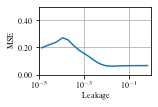

In [21]:
df = pd.DataFrame(sequential_search.all_cv_results_["step2"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_leakage", y="mean_test_score")
ax.set_xscale('log')
plt.xlabel("Leakage")
plt.ylabel("MSE")
plt.xlim((1e-5, 1e0))
plt.ylim((0.0, 0.5))
# ax.xaxis.set_major_locator(ticker.MaxNLocator(10))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.grid()
plt.savefig('KM_ESN_LR.pdf', bbox_inches='tight', pad_inches=0)

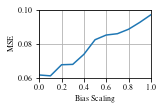

In [22]:
df = pd.DataFrame(sequential_search.all_cv_results_["step3"])
df["mean_test_score"] = -df["mean_test_score"]
fig = plt.figure()
fig.set_size_inches(2, 1.25)
ax = sns.lineplot(data=df, x="param_bias_scaling", y="mean_test_score")
plt.xlabel("Bias Scaling")
plt.ylabel("MSE")
plt.xlim((0, 1))
plt.ylim((0.06, 0.1))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
plt.grid()
plt.savefig('KM_ESN_BS.pdf', bbox_inches='tight', pad_inches=0)

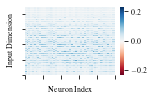

In [23]:
# idx = np.random.randint(0, 400, 50)
idx = range(50)

fig = plt.figure()
fig.set_size_inches(2, 1.25)
vmin= - np.max(sequential_search.best_estimator_.input_to_node.input_weights[:, idx])
vmax= np.max(sequential_search.best_estimator_.input_to_node.input_weights[:, idx])
ax = sns.heatmap(data=sequential_search.best_estimator_.input_to_node.input_weights[:, idx], cmap="RdBu", vmin=vmin, vmax=vmax)
ax.invert_yaxis()
ax.yaxis.set_major_locator(ticker.MaxNLocator(5))
ax.xaxis.set_major_locator(ticker.MaxNLocator(5))
plt.xlabel("Neuron Index")
plt.ylabel("Input Dimension")
# plt.imshow(sequential_search.best_estimator_.input_to_node.input_weights.todense()[:, idx])
# plt.colorbar()
plt.savefig('KM_ESN_Input_Weights.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
idx = np.random.randint(0, 50, 9)
num_row = 3
num_col = 3# plot images
fig, axes = plt.subplots(num_row, num_col, figsize=(2,1.25), sharex='all', sharey='all')
for k, i in enumerate(idx):
    ax = axes[k//num_col, k%num_col]
    im = ax.imshow(sequential_search.best_estimator_.input_to_node.input_weights[:, i].reshape(30, 30), cmap='gray')
plt.subplots_adjust(wspace=-0.63, hspace=0.1)
cbar_ax = fig.add_axes([0.78, 0.15, 0.02, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator
cb.update_ticks()
plt.savefig('KM_ESN_Input_Weights_2.pdf', bbox_inches='tight', pad_inches=0)

In [ ]:
from sklearn.metrics import accuracy_score


constant_params = sequential_search.best_estimator_.get_params()
constant_params.pop('hidden_layer_size')
constant_params.pop('random_state')
constant_params.pop('predefined_input_weights')

param_grid = {'hidden_layer_size': [50, 100, 200, 400, 800, 1600],
              'random_state': range(1, 11)}

for params in ParameterGrid(param_grid):
    if params['hidden_layer_size'] > 100:
        kmeans = MiniBatchKMeans(n_clusters=100, n_init=200, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0, random_state=params['random_state'])
        kmeans.fit(X=np.concatenate(np.concatenate((X_train, X_test))))
        w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
        w_in = np.pad(w_in, ((0, params['hidden_layer_size'] - 100), (0, 0)), mode='constant', constant_values=0)
    else:
        kmeans = MiniBatchKMeans(n_clusters=params['hidden_layer_size'], n_init=200, reassignment_ratio=0, max_no_improvement=50, init='k-means++', verbose=0, random_state=params['random_state'])
        kmeans.fit(X=np.concatenate(np.concatenate((X_train, X_test))))
        w_in = np.divide(kmeans.cluster_centers_, np.linalg.norm(kmeans.cluster_centers_, axis=1)[:, None])
    km_esn = clone(sequential_search.best_estimator_)
    km_esn.input_to_node = PredefinedWeightsInputToNode(predefined_input_weights=w_in.T)
    km_esn.set_params(**constant_params, **params)
    km_esn.fit(X=X_train, y=y_train, n_jobs=8)
    y_pred = km_esn.predict_proba(X_test)
    score = accuracy_score(np.argmax(np.concatenate(y_test), axis=1), np.argmax(np.concatenate(y_pred), axis=1))
    print("KM-ESN with params {0} achieved score of {1}".format(params, score))